## Transfer learning with ResNet.

In [15]:
#You can use a gpu to speed up training time. In colab go to runtime > "Change runtime type" > and select gpu
import tensorflow as tf
tf.test.gpu_device_name()

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

import numpy as np
import matplotlib.pyplot as plt

#from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input

MODEL_FILE = 'resnet152.model'

In [16]:
import pathlib
data_dir = pathlib.Path('imgs')
batch_size = 50
img_height = 180
img_width = 180
#class_names = train_ds.classes
class_names=['carbonate_fossil', 
             'carbonate_stalagmite',
             'carbonate_travertin',
             'igneous_basaltcolumn',
             'igneous_pahoehoe',
             'igneous_phanerocrystal',
             'malachite',
             'marble',
             'sandstone', 
             'shale']
num_classes = len(class_names)
print(class_names)
print(num_classes)

['carbonate_fossil', 'carbonate_stalagmite', 'carbonate_travertin', 'igneous_basaltcolumn', 'igneous_pahoehoe', 'igneous_phanerocrystal', 'malachite', 'marble', 'sandstone', 'shale']
10


### Data processing

In [17]:
print("Training set: ")

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    dtype = 'float32',
    rotation_range=90,
    zoom_range=[1,2],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.3
)

train_ds = train_datagen.flow_from_directory(
    data_dir,
    subset="training",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
)

print("Validation set: ")

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    dtype = 'float32',
    rotation_range=90,
    zoom_range=[1,2],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.3
)

val_ds = val_datagen.flow_from_directory(
    data_dir,
    subset="validation",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Training set: 
Found 864 images belonging to 10 classes.
Validation set: 
Found 365 images belonging to 10 classes.


### Load Pre-trained model


Load the pre-trained googlenet InceptionV3 Model directly from the keras.applications package. By specifying ```include_top=False```, we remove the final classification layers from the model. We will be replacing the top layers with our own. 

In [47]:
base_model = ResNet152(
    weights='imagenet', 
    include_top=False, 
    input_shape= (img_height,img_width,3)
)

#base_model = InceptionV3(weights='imagenet', include_top=False)

If you wish to see the structure of the InceptionV3 network, you can run the following cell. 

### Replace classification layer

Here we add the final classification layers back to the network.

In [49]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# These layers were removed by setting include_top=false, but we still want them
x = base_model.output                          # The output layer of the resNet
x = GlobalAveragePooling2D()(x)                # This layer is used to downsample the features
x = Dropout(0.5)(x)                            # This layer is used to enforce feature redundancy 

# This layer specifies our classifier output
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
print(num_classes)

10


In [48]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='resnet152.png', show_shapes=True, show_layer_names=True)

We only want to train the final layers of the network, so we set this flag to ensure that the pre-trained layers stay as they were.

In [50]:
for layer in base_model.layers:
    layer.trainable = False # Set this to True if you want to re-train the entire network.

In [51]:
# Compile the network:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [52]:
ACCURACY_THRESHOLD = 0.8000

from tensorflow.keras.callbacks import Callback as cb
# Implement callback function to stop training
class myCallback(cb): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') >= ACCURACY_THRESHOLD):   
            print("\nReached %2.2f%% accuracy, so stopping training" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

callbacks = myCallback()

### Train the network

In [53]:
EPOCHS = 80
STEPS_PER_EPOCH = 1
VALIDATION_STEPS = 1

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_ds,
    #validation_steps=VALIDATION_STEPS,
    callbacks=[callbacks]
)
  
model.save(MODEL_FILE)

Epoch 1/80
1/1 [==============================] - 145s 145s/step - loss: 4.2437 - accuracy: 0.0800 - val_loss: 3.6650 - val_accuracy: 0.1753
Epoch 2/80
1/1 [==============================] - 143s 143s/step - loss: 4.5482 - accuracy: 0.1000 - val_loss: 2.3474 - val_accuracy: 0.3041
Epoch 3/80
1/1 [==============================] - 143s 143s/step - loss: 2.9488 - accuracy: 0.2000 - val_loss: 2.3147 - val_accuracy: 0.3041
Epoch 4/80
1/1 [==============================] - 140s 140s/step - loss: 3.0686 - accuracy: 0.2200 - val_loss: 2.0420 - val_accuracy: 0.3616
Epoch 5/80
1/1 [==============================] - 139s 139s/step - loss: 2.7480 - accuracy: 0.2600 - val_loss: 1.9466 - val_accuracy: 0.3863
Epoch 6/80
1/1 [==============================] - 138s 138s/step - loss: 2.2442 - accuracy: 0.4000 - val_loss: 1.8878 - val_accuracy: 0.4192
Epoch 7/80
1/1 [==============================] - 138s 138s/step - loss: 2.2747 - accuracy: 0.4000 - val_loss: 1.5601 - val_accuracy: 0.4740
Epoch 8/80
1/

Epoch 59/80
1/1 [==============================] - 135s 135s/step - loss: 0.7632 - accuracy: 0.7000 - val_loss: 0.7352 - val_accuracy: 0.7863
Epoch 60/80
1/1 [==============================] - 136s 136s/step - loss: 0.8819 - accuracy: 0.6600 - val_loss: 0.6435 - val_accuracy: 0.7945
Epoch 61/80
1/1 [==============================] - 135s 135s/step - loss: 0.7071 - accuracy: 0.8000 - val_loss: 0.5894 - val_accuracy: 0.7918
Epoch 62/80
1/1 [==============================] - ETA: 0s - loss: 0.6157 - accuracy: 0.7600
Reached 80.00% accuracy, so stopping training
1/1 [==============================] - 139s 139s/step - loss: 0.6157 - accuracy: 0.7600 - val_loss: 0.5931 - val_accuracy: 0.8137
INFO:tensorflow:Assets written to: resnet152.model\assets


Now lets visualize how accuracy and loss changed with each epoch.


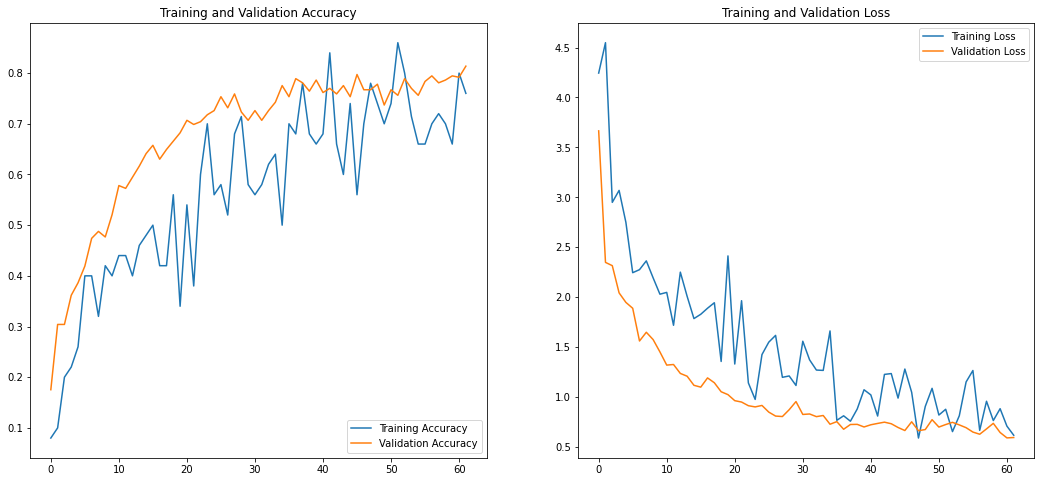

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_actual = len(history.history['loss'])
epochs_range = range(epochs_actual)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Test Trained Network

Finally, we can see how our trained network does classifying a new image. 

In [18]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

In [19]:
from tensorflow.keras.models import load_model
model = load_model(MODEL_FILE)

In [20]:
# Method to use model for prediction:
# Predict pre-processes the input so that it matches the format expected by the 
# network, then runs model.predict which provides the class predictions
def pred(model, img):
    img = img.resize((img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    results = model.predict(x)
    return results[0]

# Make prediction for all test images:
results = []
for filename in val_ds.filenames:
    img = image.load_img("imgs/" + filename)
    results.append(np.argmax(pred(model, img)))
results = np.array(results).astype(np.int32)

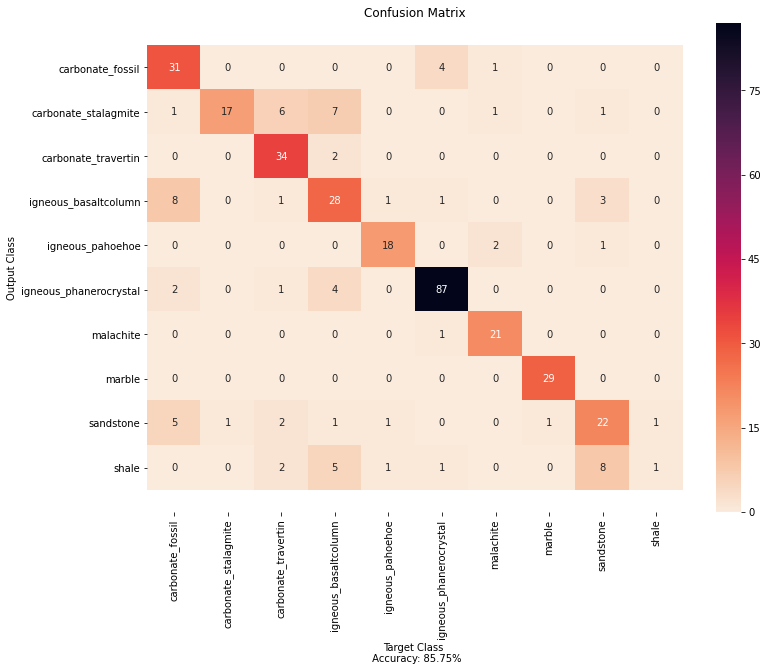

In [21]:

# Method to plot confusion matrix:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def plot_confusion_matrix(y_pred, y_true, numLabel):
    
    # Compute confusion matrix:
    accuracy = (np.sum(np.logical_and(y_pred, y_true))/ len(y_true)) * 100
    c_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(c_matrix, index = [i for i in class_names],
                  columns = [i for i in class_names])
    plt.figure(figsize = (12,9))
    ax = sn.heatmap(df_cm, annot=True, cmap=sn.cm.rocket_r)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title("Confusion Matrix")
    plt.ylabel('Output Class')
    plt.xlabel('Target Class \n Accuracy: ' + '%.2f'%accuracy + "%")
    
# Confusion Matrix:
plot_confusion_matrix(results, val_ds.labels, 4)

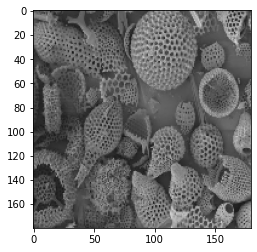

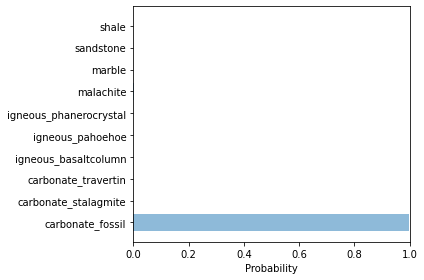

This image most likely belongs to carbonate_fossil with a 23.17 percent confidence.


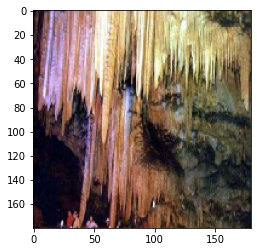

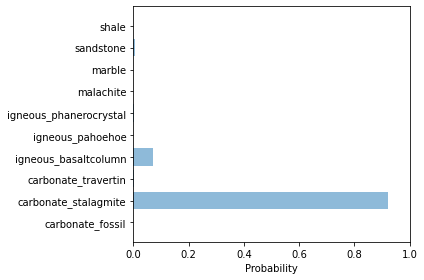

This image most likely belongs to carbonate_stalagmite with a 21.67 percent confidence.


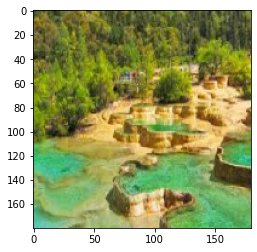

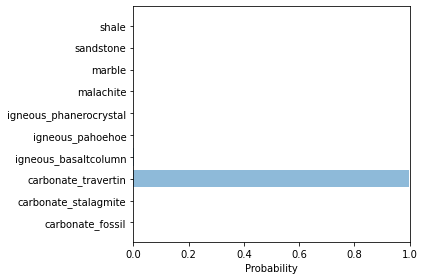

This image most likely belongs to carbonate_travertin with a 23.16 percent confidence.


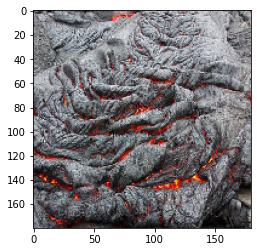

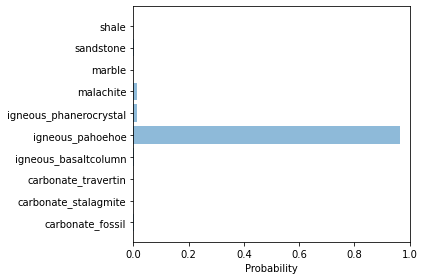

This image most likely belongs to igneous_pahoehoe with a 22.48 percent confidence.


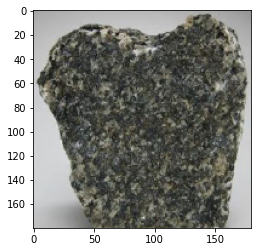

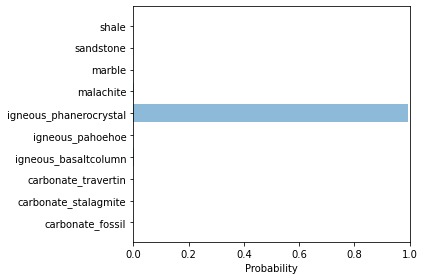

This image most likely belongs to igneous_phanerocrystal with a 23.09 percent confidence.


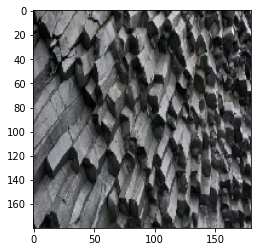

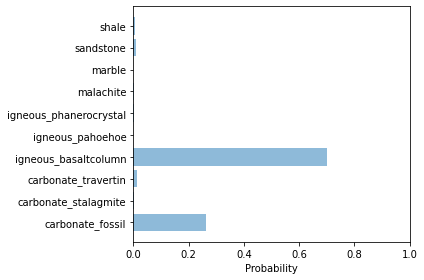

This image most likely belongs to igneous_basaltcolumn with a 17.77 percent confidence.


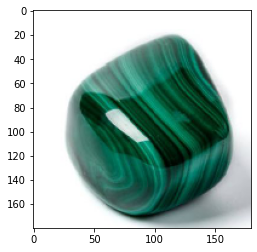

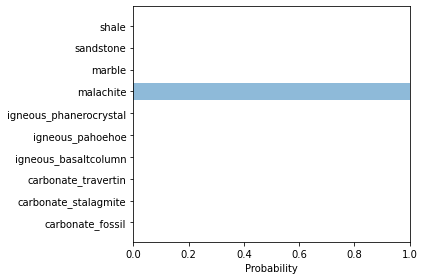

This image most likely belongs to malachite with a 23.19 percent confidence.


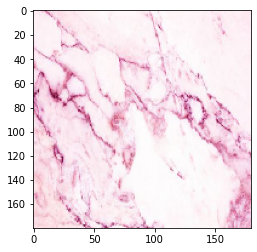

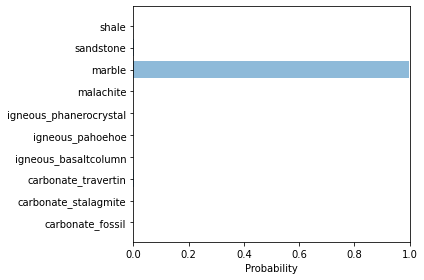

This image most likely belongs to marble with a 23.12 percent confidence.


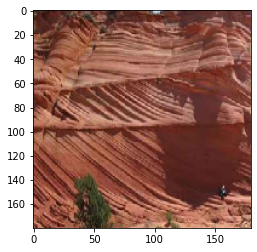

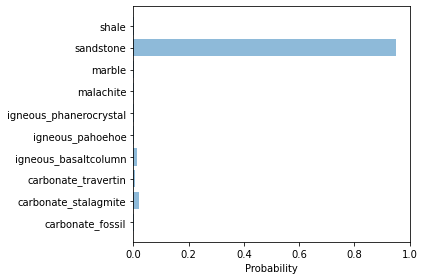

This image most likely belongs to sandstone with a 22.21 percent confidence.


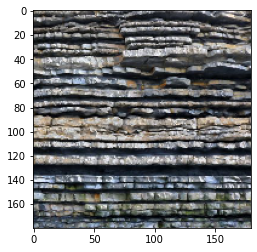

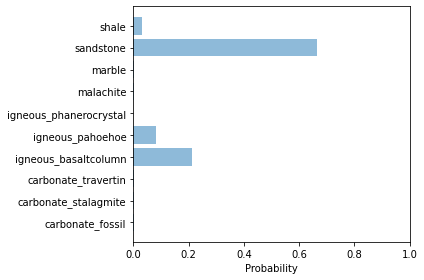

This image most likely belongs to sandstone with a 17.18 percent confidence.


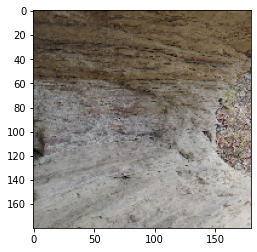

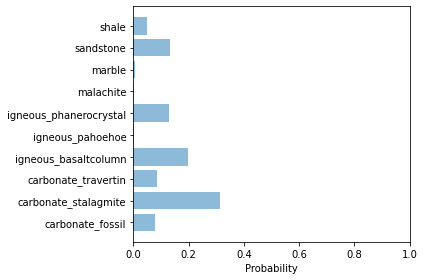

This image most likely belongs to carbonate_stalagmite with a 12.35 percent confidence.


In [22]:
# Test individual image:
img_names = ['carbonate_fossil.JPG', 
                'carbonate_stalagmite.JPG',        
                'carbonate_travertin.JPG',
                'igneous_pahoehoe.JPG',
                'igneous_phanerocrystal.JPG',    
                'igneous_basaltcolumn.JPG',
                'malachite.JPG',
                'marble.JPG',
                'sandstone.JPG',   
                'shale.JPG',
                'shale2.JPG']
dir_name = 'single_test_imgs/'
for i in range(len(img_names)):
    img_names[i] = dir_name+img_names[i]


for img_name in img_names:
    # Plot the original image
    plt.figure()
    img = image.load_img(img_name, target_size=(img_height, img_width))
    result = pred(model, img)
    plt.imshow(img)

    # Visualize the predicted likelihood of each class
    plt.figure()
    labels = class_names
    plt.barh(range(num_classes), result, alpha=0.5)
    plt.yticks(range(num_classes),labels)
    plt.xlabel('Probability')
    plt.xlim(0,1)
    plt.tight_layout()
    plt.show()

    score = tf.nn.softmax(result)
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )